# TCAV — Images 

This notebook trains CAVs and plots variability.


In [1]:

# Import shim
import sys, pathlib
for p in (pathlib.Path.cwd().parent / "src", pathlib.Path.cwd().parents[1] / "src"):
    if (p / "tcavlab").exists():
        sys.path.insert(0, str(p))
import tcavlab
print("tcavlab path:", tcavlab.__file__)


tcavlab path: /Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav_variability/src/tcavlab/__init__.py


In [2]:

import os, pickle
import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
from tcavlab import (
    ExperimentConfig, DatasetConfig,
    Concept, train_cav, sample_train_cav, method_names,
    get_activations_from_tensor, get_gradient_at_layer,
    plot_variance_vs_n, plot_tcav_score_variance,
    precompute_cavs_for_layer,
    cav_variability_analysis_cached, sensitivity_variance_analysis_cached, tcav_score_variance_analysis_cached,
)
from tcavlab.models.vision import available_models, choose_model
from tcavlab.datasets.images import load_images_as_tensor
from tcavlab.utils import device_auto, set_all_seeds, ensure_dir
from tcavlab.analysis_utils import load_cav_vector_variance_data_cached, precompute_gradients_for_class


In [ ]:

# -----------------------------
# 1) Configuration
# -----------------------------
METHOD = "hinge"        # "dom", "logistic", "hinge"
MODEL = "resnet50"    # "resnet50", "googlenet", "mobilenet_v3_large", "vit_b_16"
print("Available models:", available_models())

dataset = DatasetConfig(                    
    name="images",
    concepts=["striped", "zigzagged", "dotted"],
    target_class_name="zebra",
    target_class_index=340,
    data_paths={
        "concepts_root": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav/TCAV_Images/data/concepts",
        "random_dir": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav/TCAV_Images/data/concepts/random",
        "class_dir": "/Users/juliawenkmann/Documents/CodingProjects/tcav_projects/tcav/TCAV_Images/data/imagenet/zebra",
    },
)

cfg = ExperimentConfig(
    dataset=dataset,
    method=METHOD,
    model_key=MODEL,
    n_values=range(10, 310, 10),
    runs=10,
    sets_per_run=10,
    out_dir=f"artifacts/images/{MODEL}/{METHOD}",  # CAV files will be saved under: out_dir/{layer}/{concept}/{n}/run_{i}.pkl
    seed=42,
)

set_all_seeds(cfg.seed)
DEVICE = device_auto()
print("Using device:", DEVICE)

# Cache flags
CACHE_DIR = os.path.join(cfg.out_dir, "cache")
LOAD_IF_EXISTS = False
os.makedirs(CACHE_DIR, exist_ok=True)


Available models: ['resnet50', 'googlenet', 'mobilenet_v3_large', 'vit_b_16']
Using device: mps


In [4]:

# -----------------------------
# 2) Model and data
# -----------------------------
model, layers, preprocess, device = choose_model(cfg.model_key)
print("Layers:", layers)

concept_tensors = {}
for c in cfg.dataset.concepts:
    concept_dir = os.path.join(cfg.dataset.data_paths["concepts_root"], c)
    concept_tensors[c] = load_images_as_tensor(concept_dir, preprocess, DEVICE)
    print(f"Loaded '{c}' with {len(concept_tensors[c])} images")

random_tensor = load_images_as_tensor(cfg.dataset.data_paths["random_dir"], preprocess, DEVICE)
class_tensor = load_images_as_tensor(cfg.dataset.data_paths["class_dir"], preprocess, DEVICE)
print("Loaded random:", len(random_tensor), "target class:", len(class_tensor))


Layers: ['layer2', 'layer3', 'layer4']
Loaded 'striped' with 100 images
Loaded 'zigzagged' with 100 images
Loaded 'dotted' with 100 images
Loaded random: 913 target class: 40


In [5]:

# -----------------------------
# 3) Precompute and save CAVs (per concept & layer)
# -----------------------------
for layer in layers:
    print(f"Calculating CAVs for layer: {layer}")
    for concept in cfg.dataset.concepts:
        concept_acts = get_activations_from_tensor(model, concept_tensors[concept], layer, DEVICE).numpy()
        random_acts  = get_activations_from_tensor(model, random_tensor, layer, DEVICE).numpy()
        base_dir = os.path.join(cfg.out_dir, layer, concept)
        ensure_dir(base_dir)
        precompute_cavs_for_layer(
            X_pos=concept_acts,
            X_neg=random_acts,
            layer_name=layer,
            method=cfg.method,
            n_values=cfg.n_values,
            runs=cfg.runs,
            sets_per_run=cfg.sets_per_run,
            out_dir=base_dir,
            seed=cfg.seed,
        )
print("CAV files saved under", cfg.out_dir)


Calculating CAVs for layer: layer2
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_0.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_1.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_2.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_3.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_4.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_5.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_6.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_7.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_8.pkl
CAV file already exists, skipping: artifacts/images/resnet50/dom/layer2/striped/10/run_9.pkl
CAV file already exists, skipping: 

KeyboardInterrupt: 

===== Analyzing Layer: layer2 =====
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer2_dom.pdf


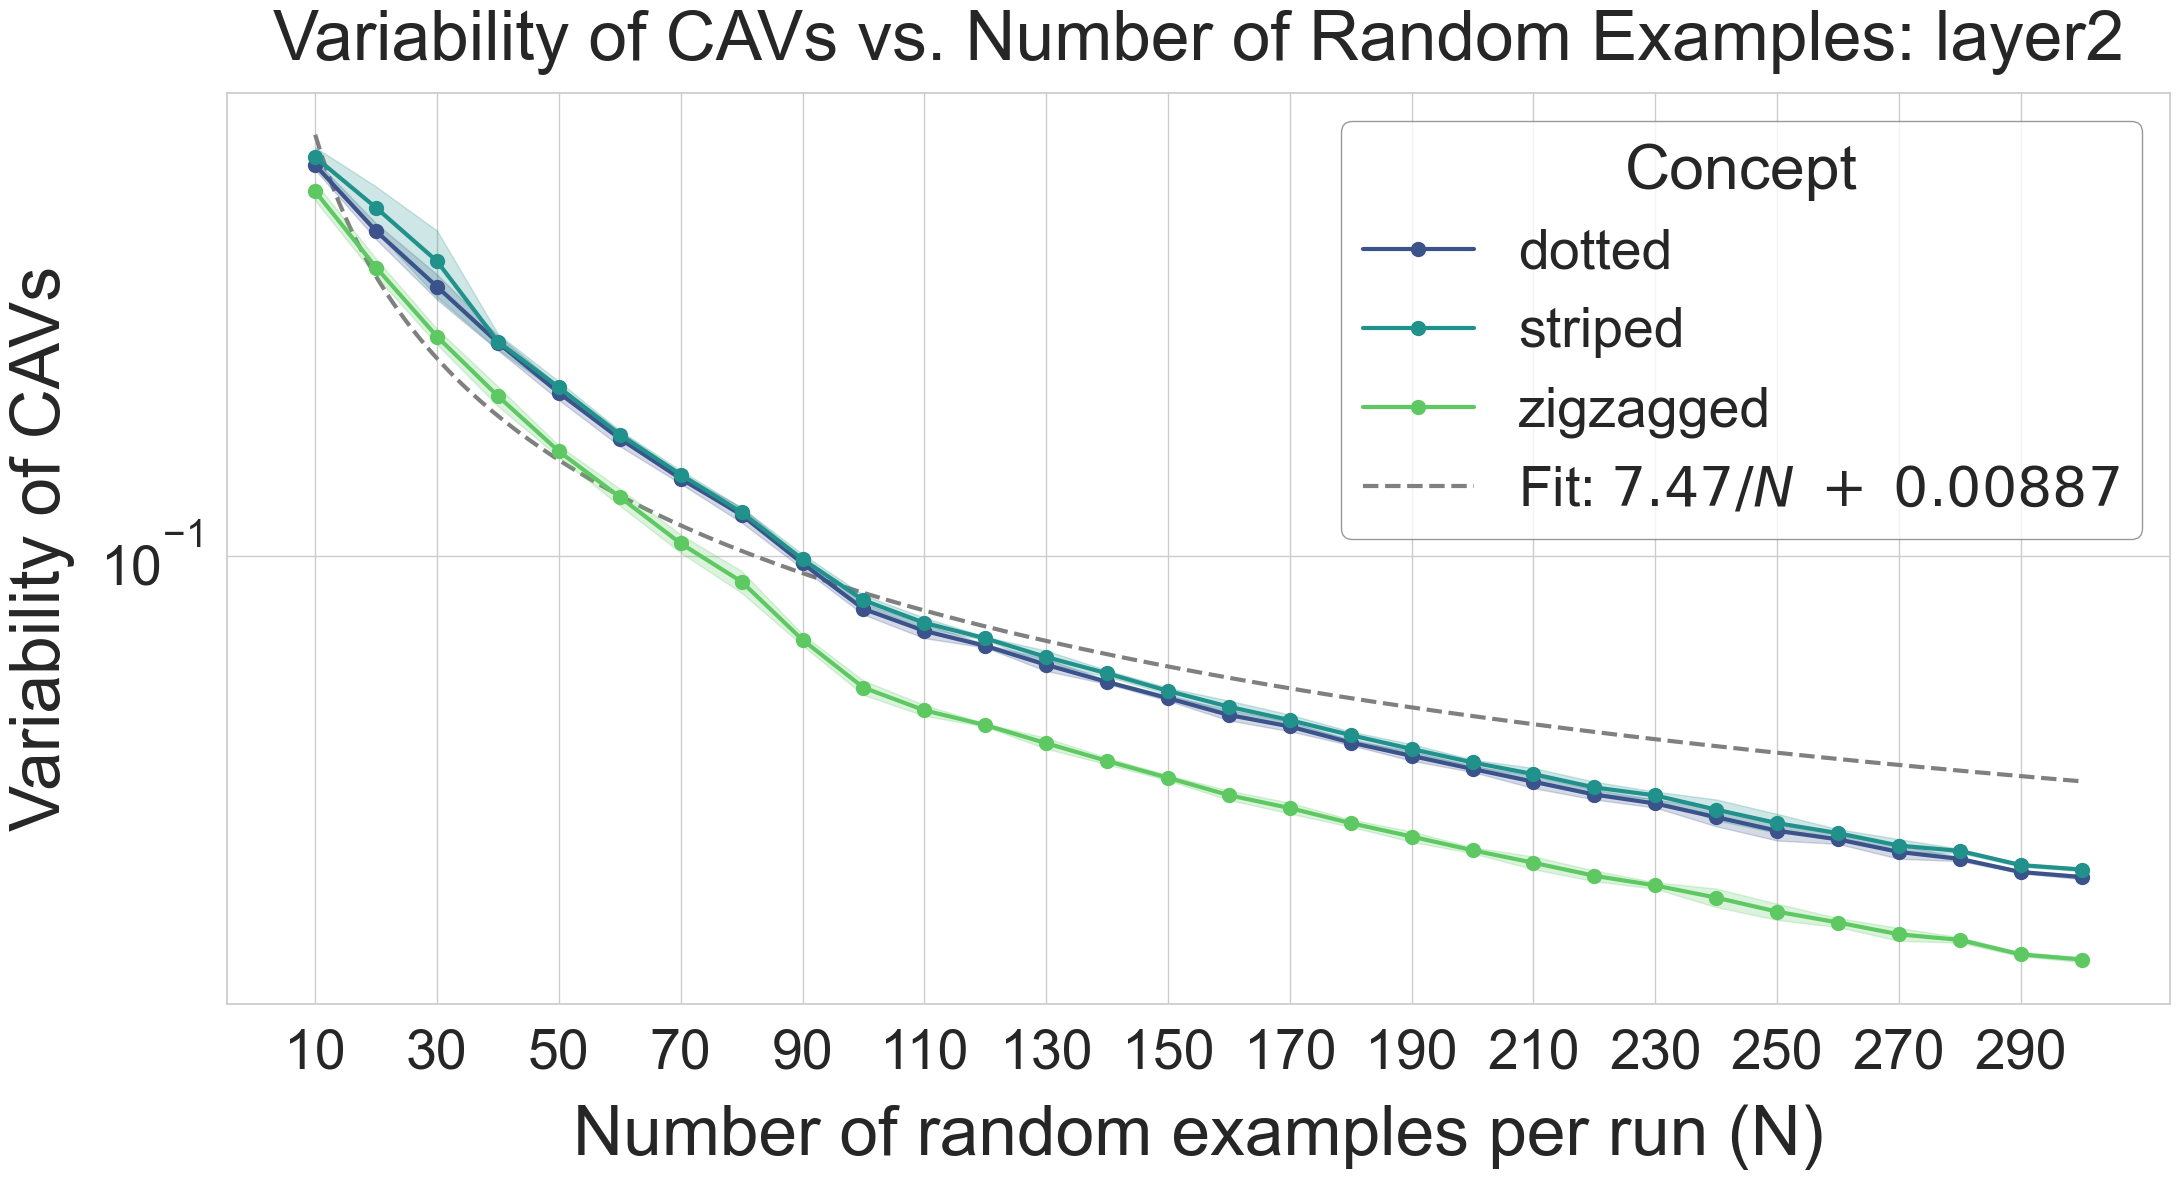

===== Analyzing Layer: layer3 =====
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer3_dom.pdf


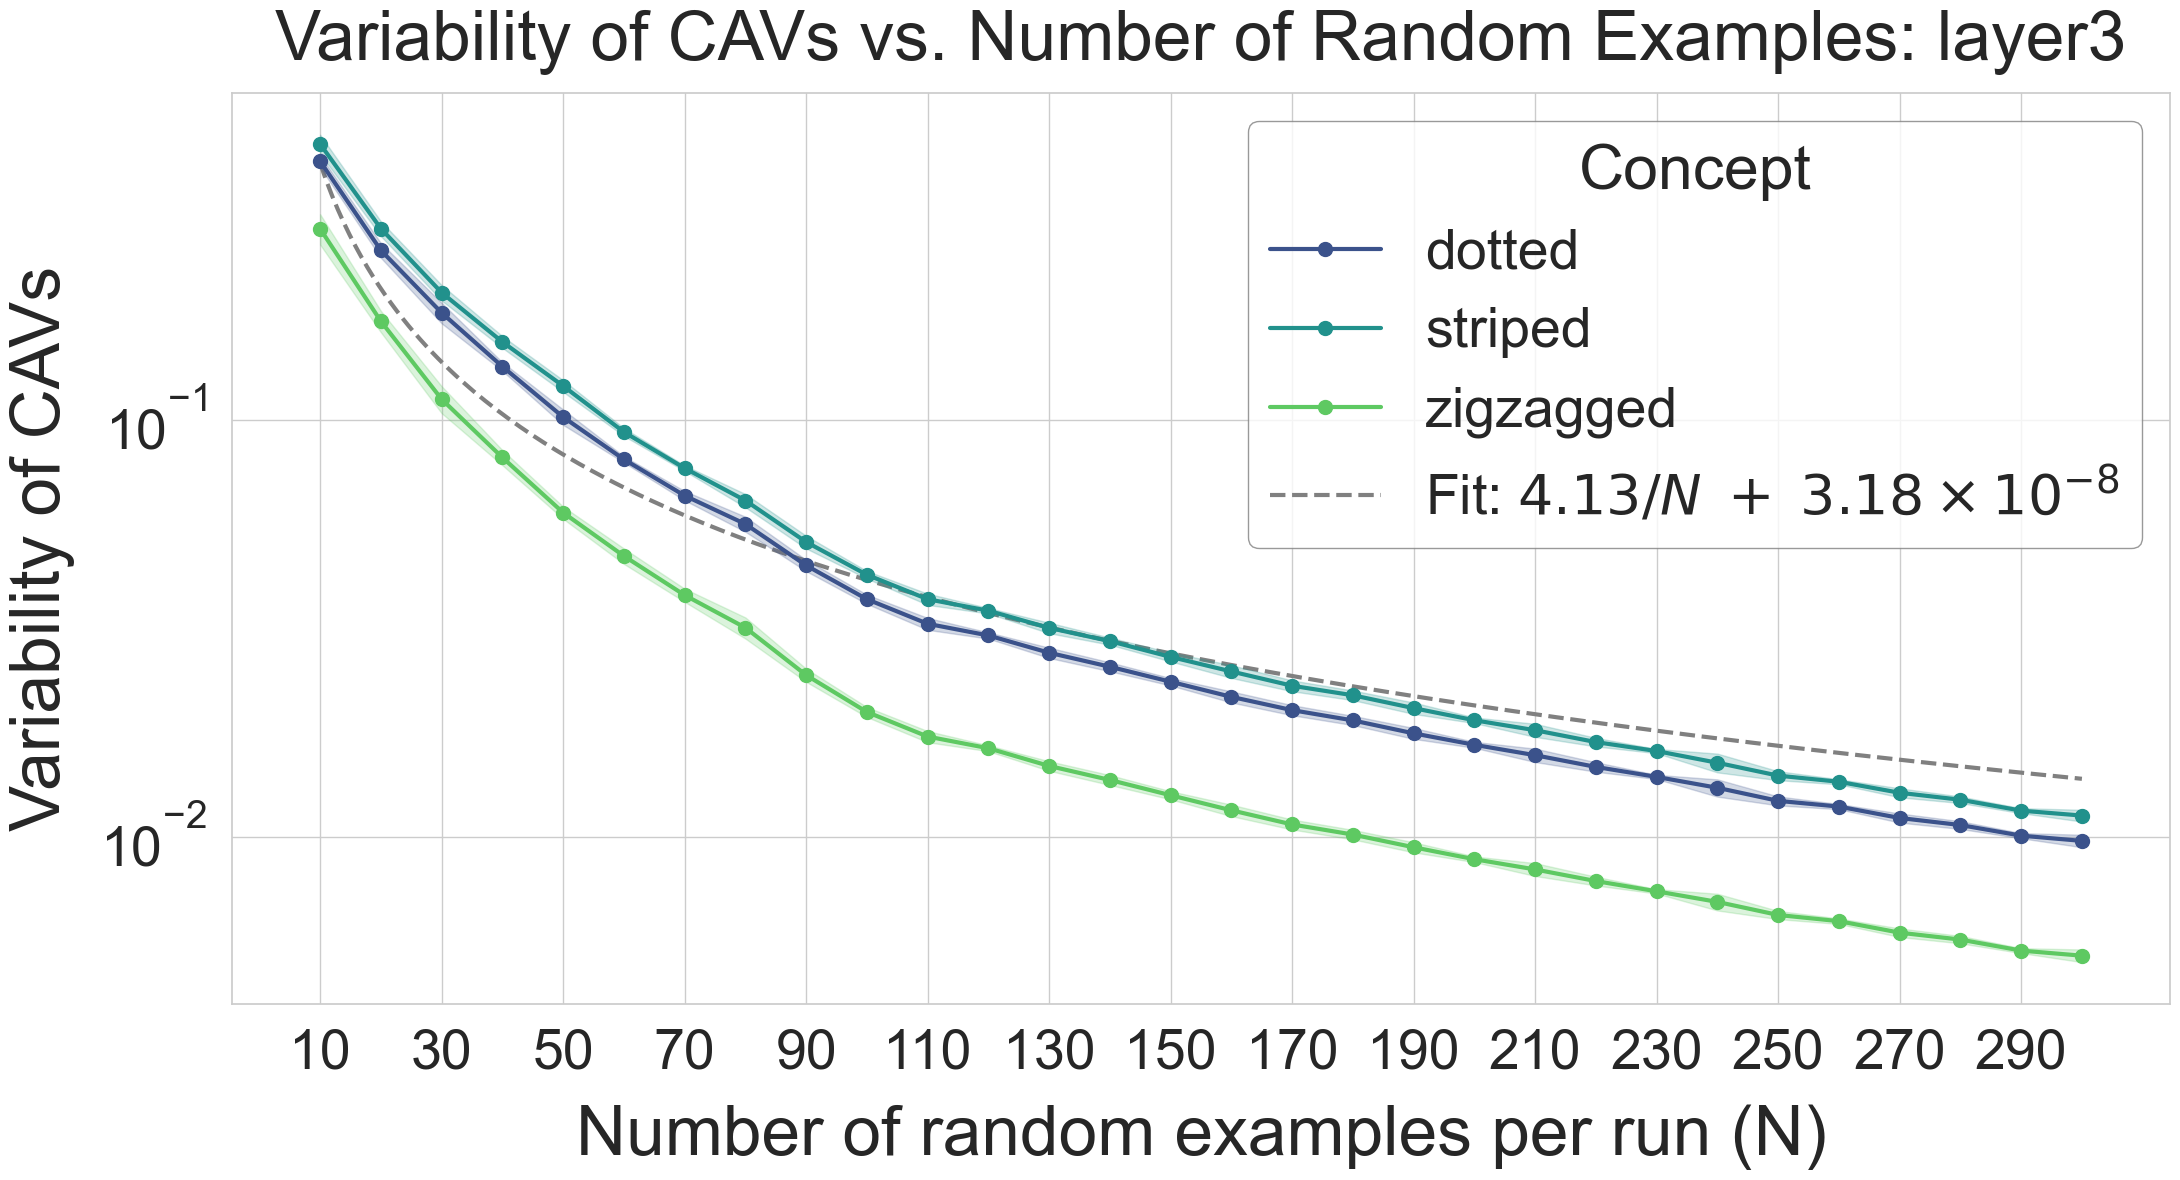

===== Analyzing Layer: layer4 =====
Plot saved to artifacts/images/resnet50/dom/plots/cav_vector_variance_resnet50_layer4_dom.pdf


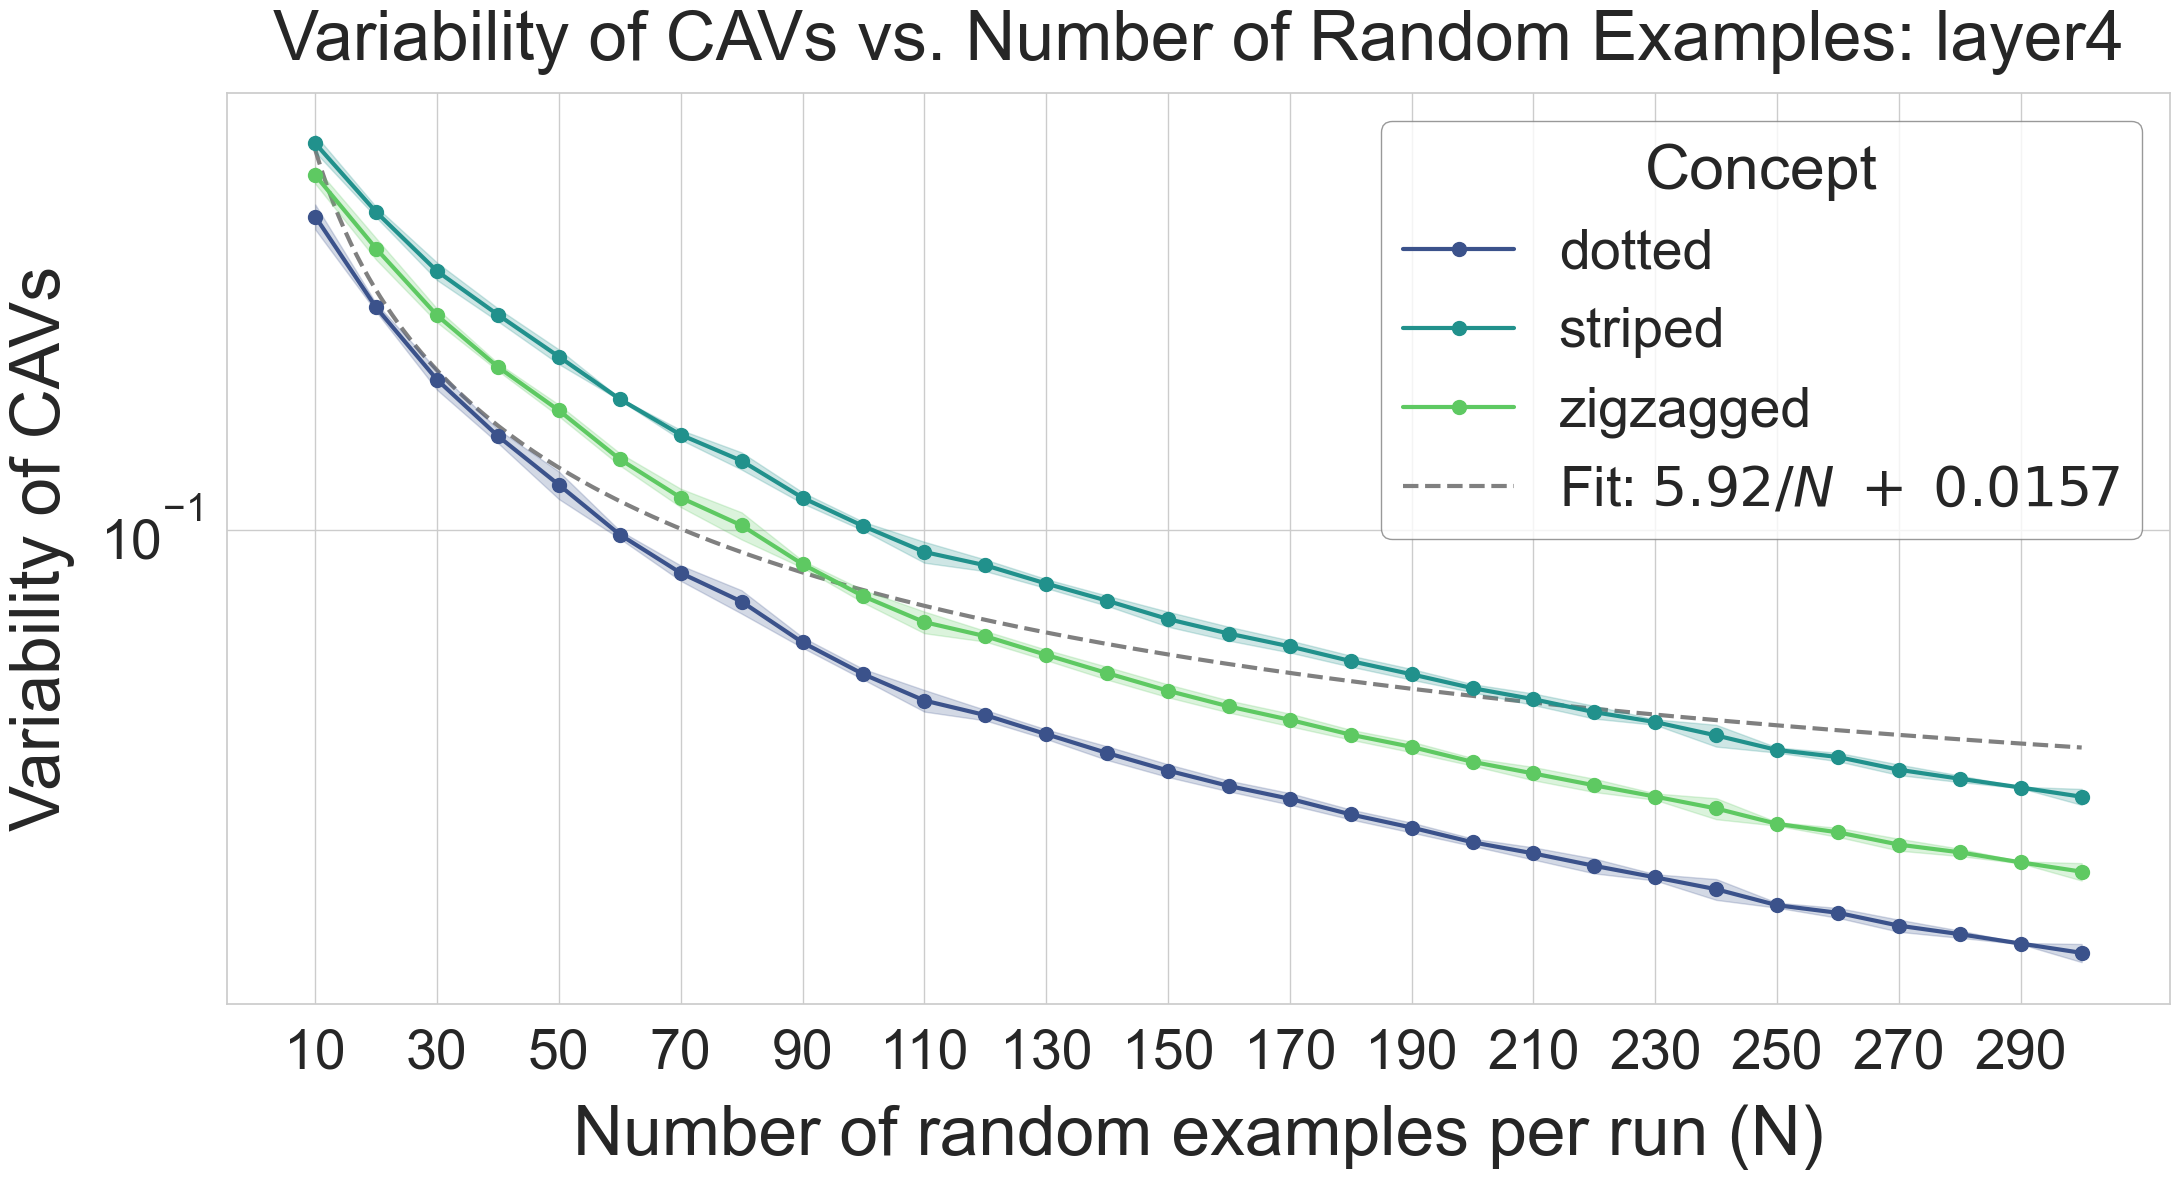

In [22]:

# -----------------------------
# 4) Your variability definition + styling (trace variance over CAV vectors)
# -----------------------------
for layer in layers:
    print(f"===== Analyzing Layer: {layer} =====")
    df_cav_variance = load_cav_vector_variance_data_cached(
        layer=layer,
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"trace_variance__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_cav_variance,
        layer=layer,
        title=f"Variability of CAVs vs. Number of Random Examples: {layer}",
        ylabel="Variability of CAVs",
        save_path=os.path.join(cfg.out_dir, "plots", f"cav_vector_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"cav_vector_variance_{MODEL}_{layer}_{METHOD}",
        load_if_exists=LOAD_IF_EXISTS,
        band="sd",
        save_bundle=True,
    )


Plot saved to artifacts/images/resnet50/logistic/plots/sensitivity_variance_resnet50_layer2_logistic.pdf


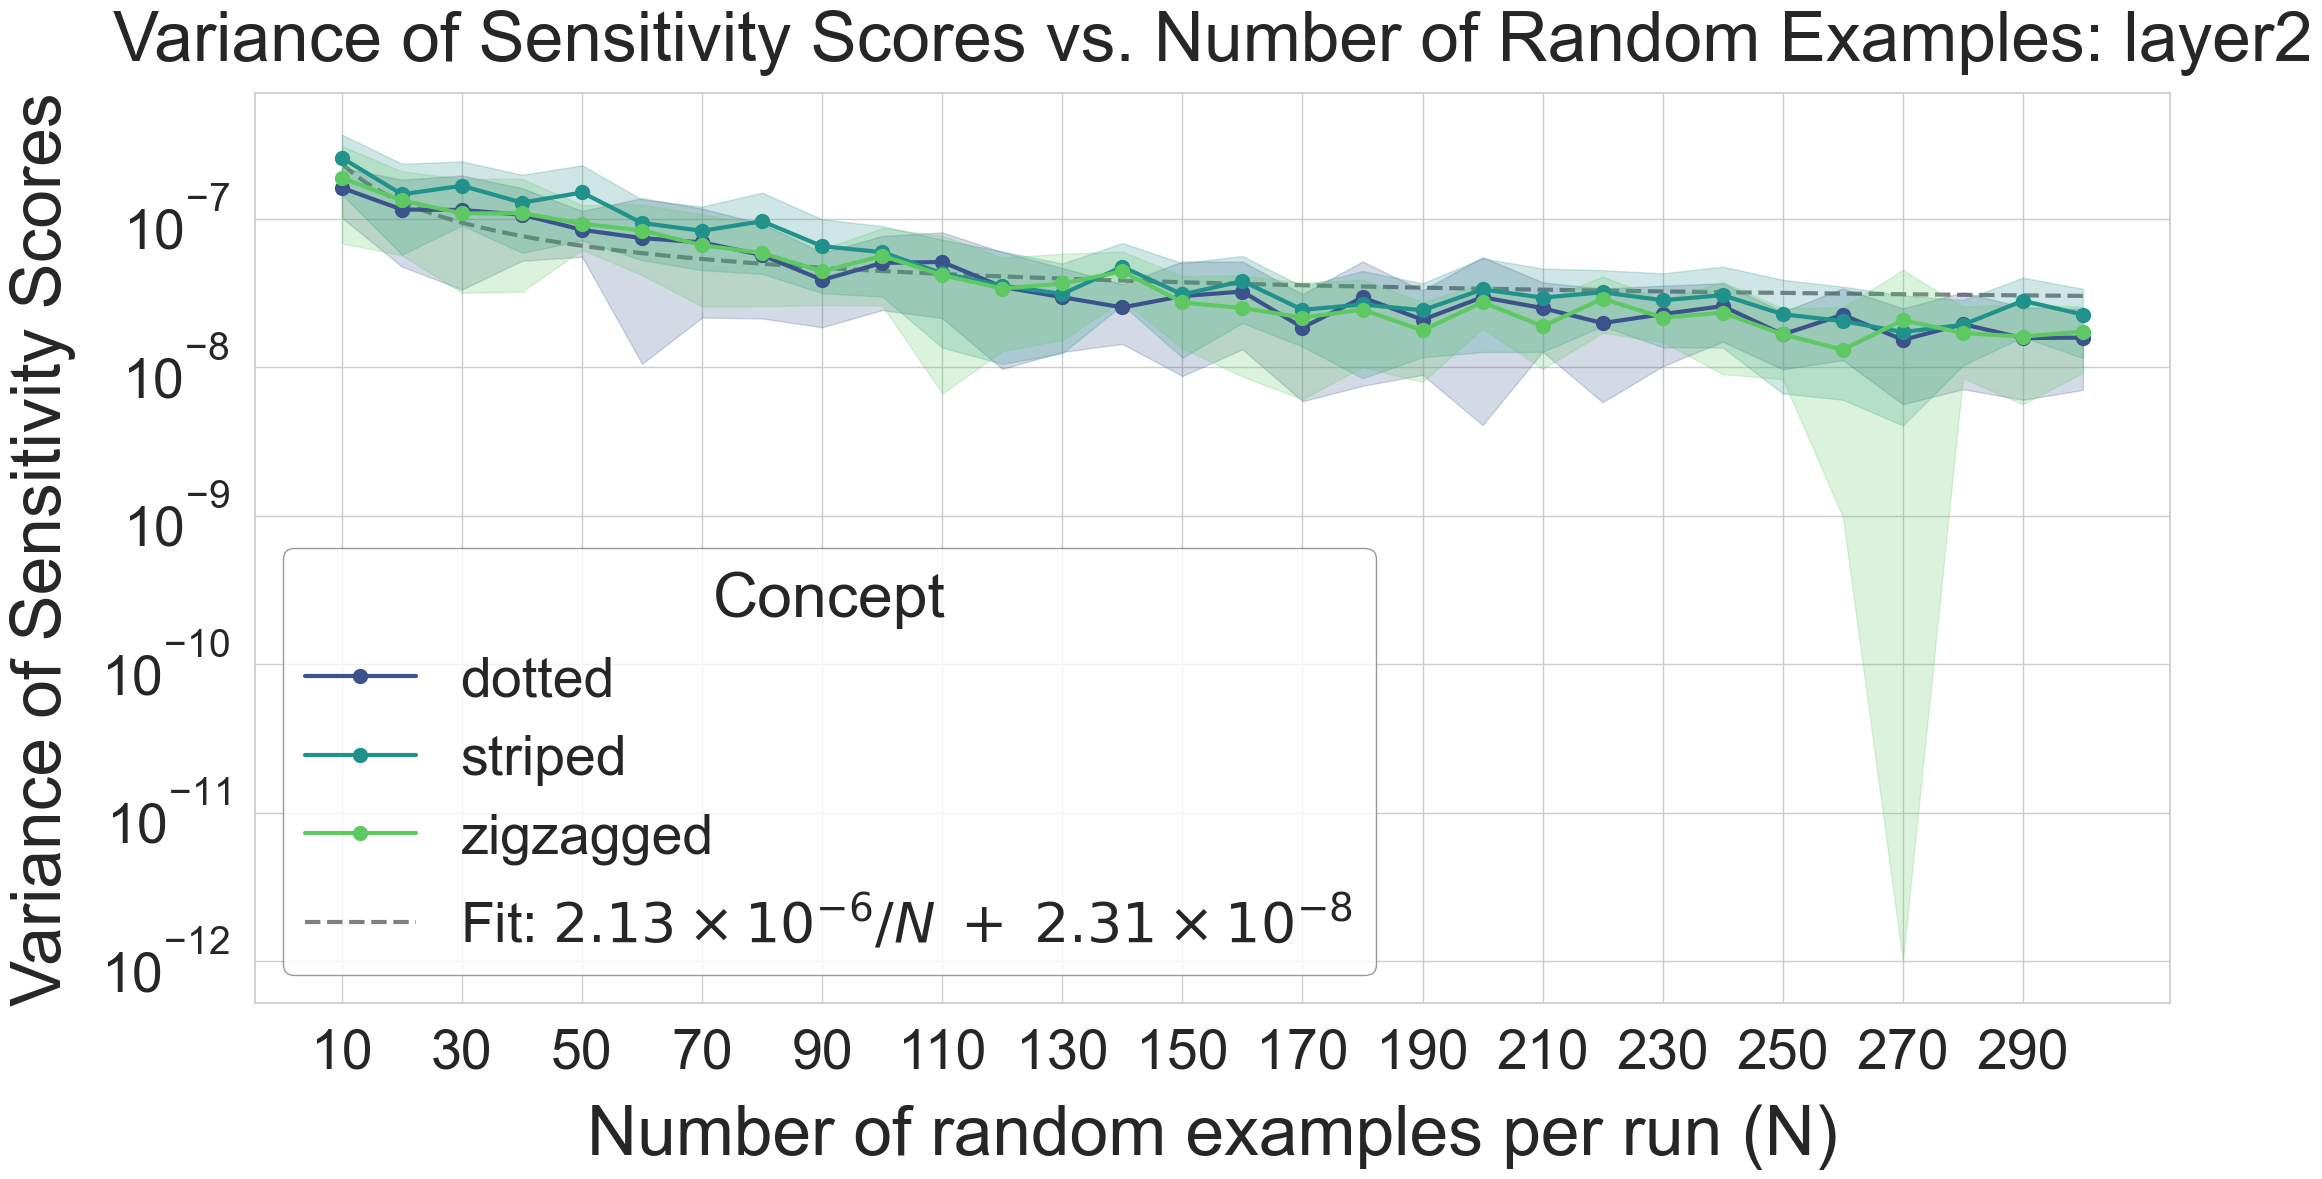

Plot saved to artifacts/images/resnet50/logistic/plots/sensitivity_variance_resnet50_layer3_logistic.pdf


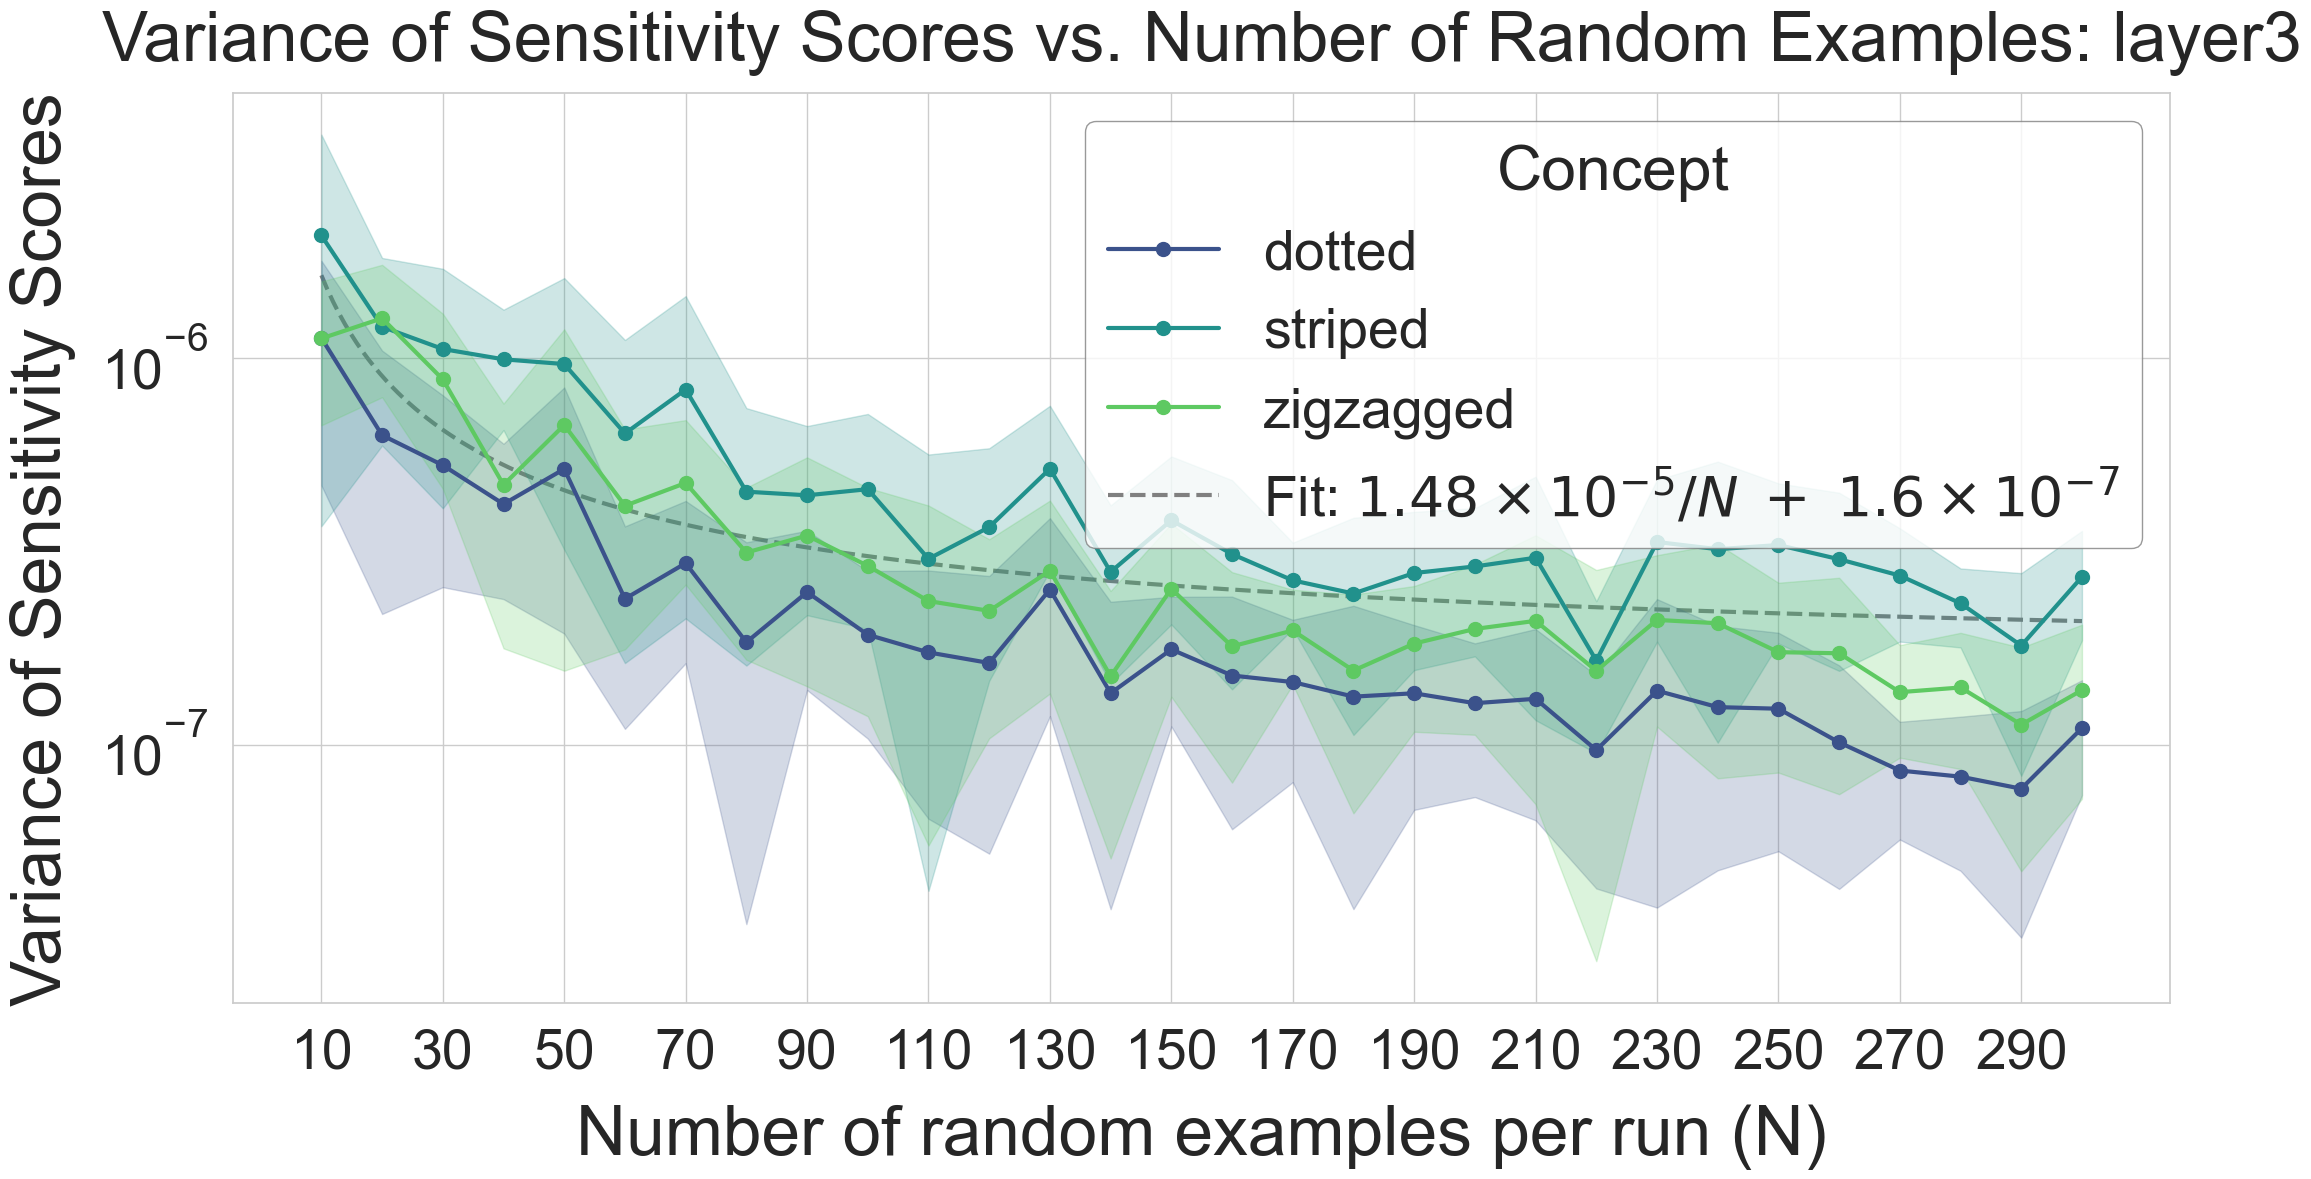

Plot saved to artifacts/images/resnet50/logistic/plots/sensitivity_variance_resnet50_layer4_logistic.pdf


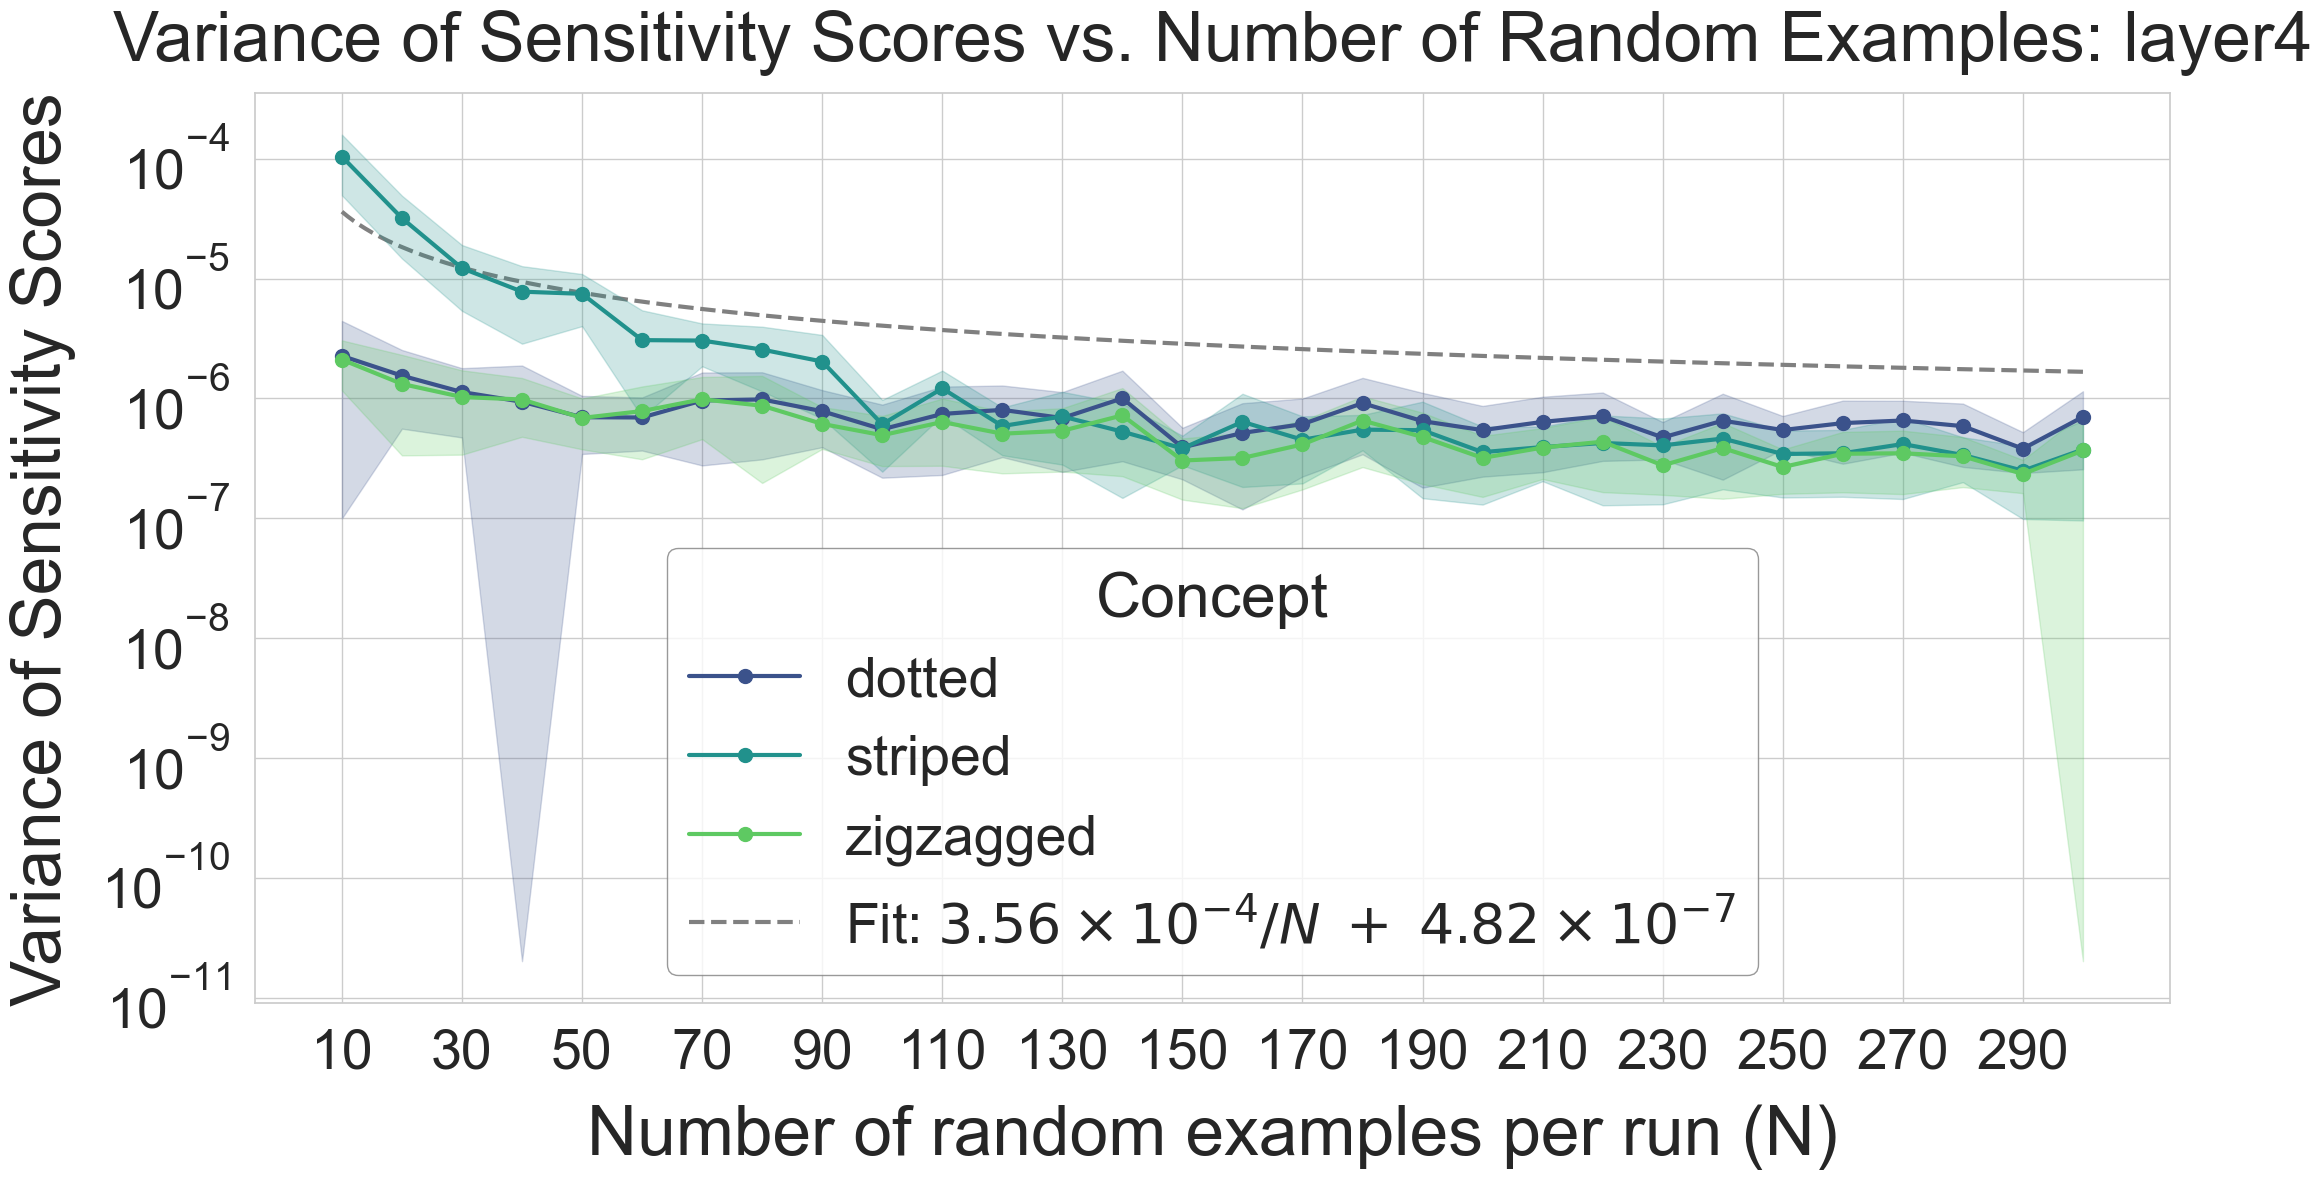

In [15]:

# -----------------------------
# 5) Sensitivity & TCAV score variance using your original definitions
#    - Sensitivity variance: variance over (cav · single-gradient-vector) across CAVs
#    - TCAV score variance: variance across CAVs of the fraction of positives over class gradients
# -----------------------------
from tcavlab.analysis_utils import (
    load_sensitivity_score_variance_data_cached,
    calculate_tcav_score_variance_cached
)

# (a) Compute a single gradient vector per layer for one target image (first example)
single_grad_by_layer = {}
first_img = class_tensor[0].unsqueeze(0).to(DEVICE)
for layer in layers:
    g = get_gradient_at_layer(model, first_img, layer, cfg.dataset.target_class_index, DEVICE)
    if g is not None:
        single_grad_by_layer[layer] = g[0]  # shape [D]
    else:
        print("No gradient for", layer)

# (b) Compute gradients for all class images per layer (for TCAV score variance)
grads_by_layer = precompute_gradients_for_class(model, class_tensor, layers, cfg.dataset.target_class_index, DEVICE)

# (c) Plot sensitivity variance per layer (all concepts on one figure)
for layer in layers:
    if layer not in single_grad_by_layer:
        print("Skipping sensitivity plot for", layer, "(no single gradient).")
        continue
    df_sens = load_sensitivity_score_variance_data_cached(
        layer=layer,
        gradient_vector=single_grad_by_layer[layer],
        cav_output_dir=cfg.out_dir,
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        cache_dir=CACHE_DIR,
        cache_key=f"sens_score_var__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    plot_variance_vs_n(
        df=df_sens,
        layer=layer,
        title=f"Variance of Sensitivity Scores vs. Number of Random Examples: {layer}",
        ylabel="Variance of Sensitivity Scores",
        save_path=os.path.join(cfg.out_dir, "plots", f"sensitivity_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        fit_thresholds=[0],
        cache_dir=CACHE_DIR,
        cache_key=f"sens_var_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )

Plot saved to artifacts/images/resnet50/logistic/plots/tcav_score_variance_resnet50_layer2_logistic.pdf


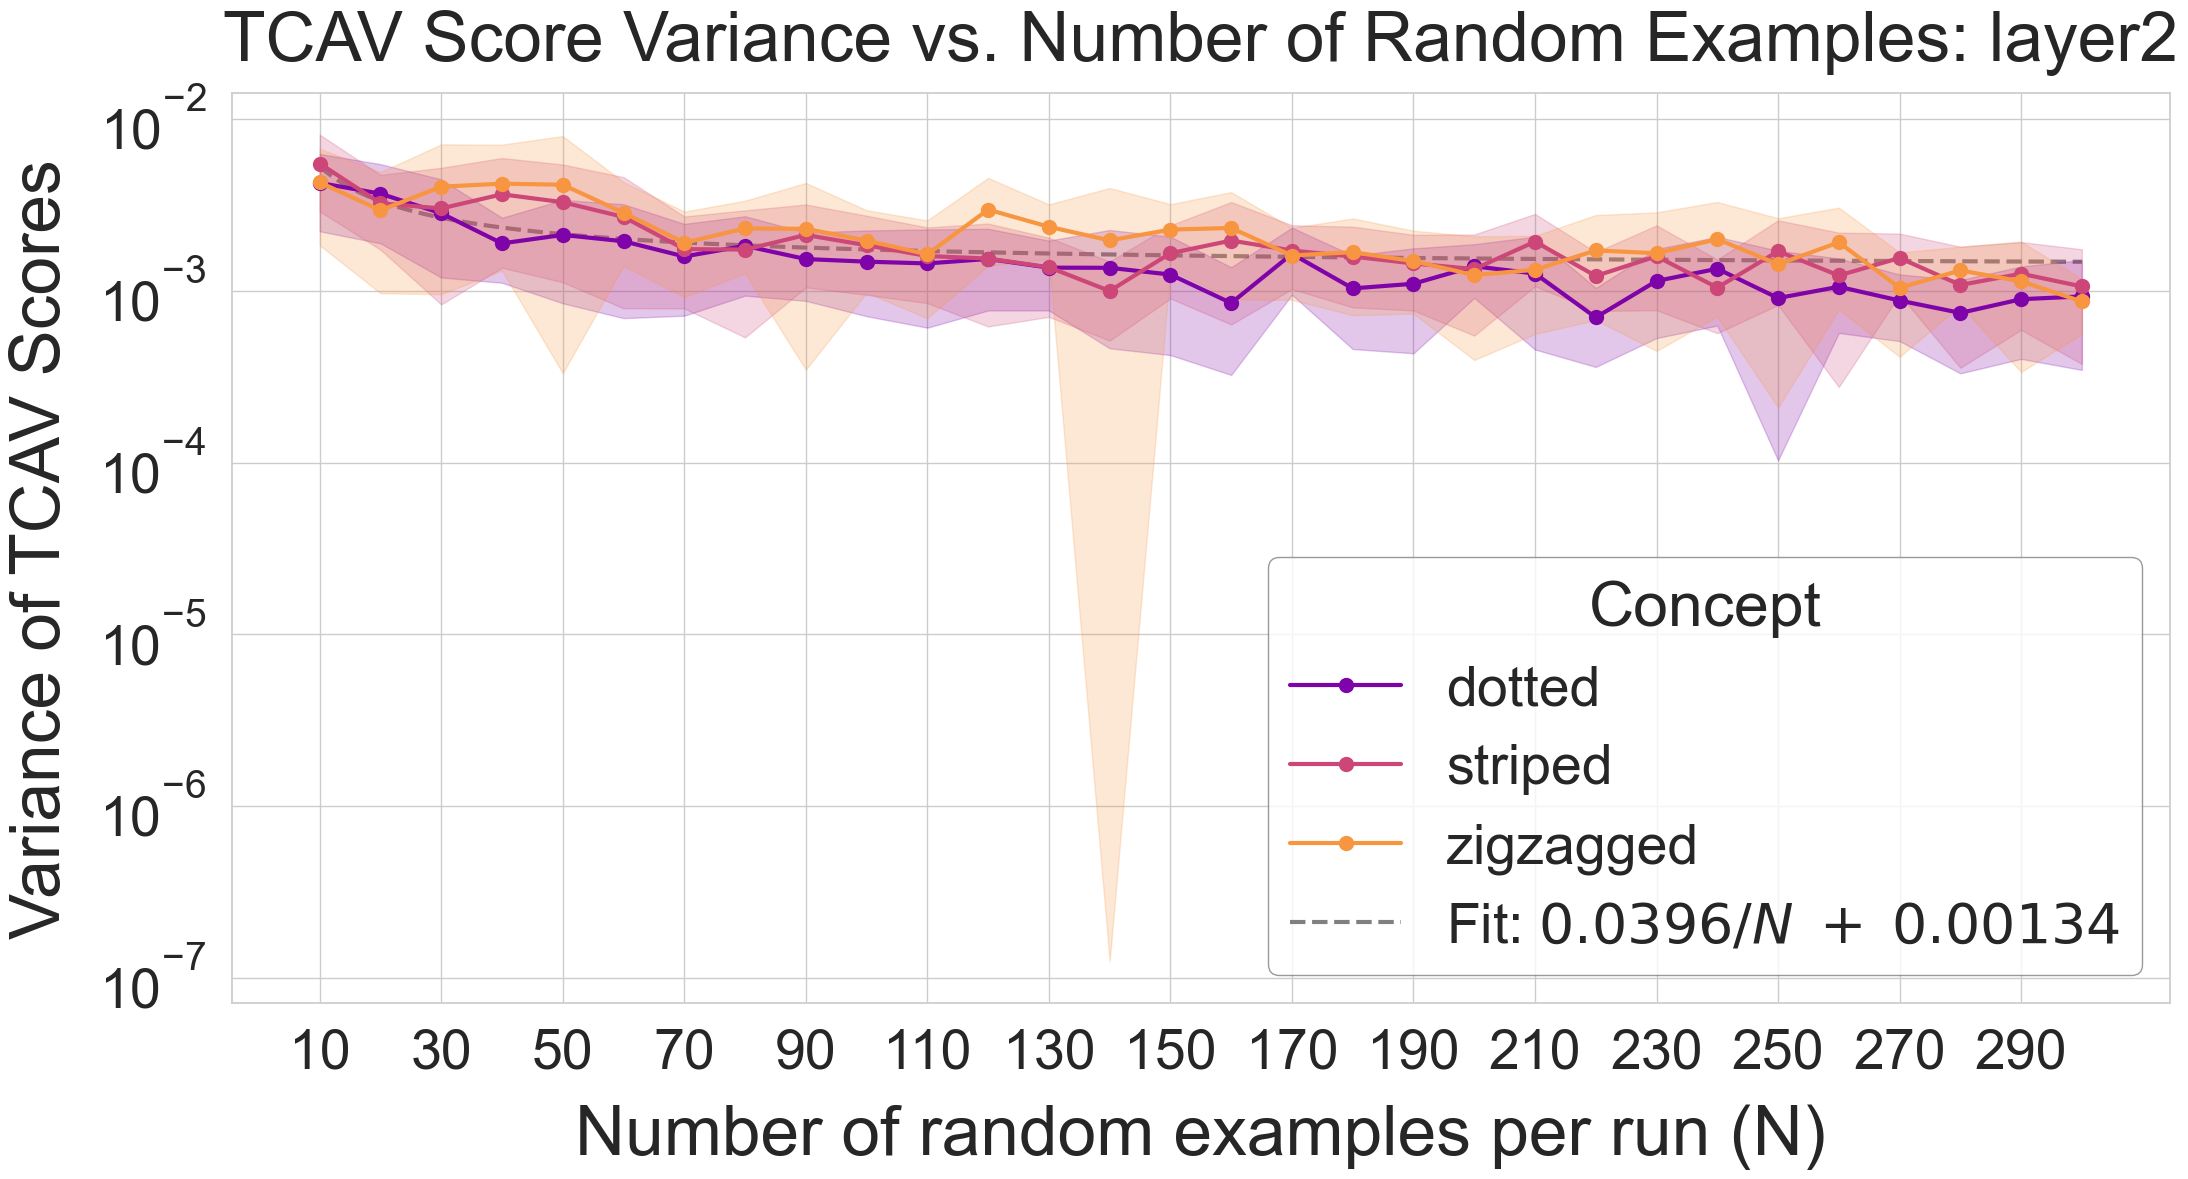

Plot saved to artifacts/images/resnet50/logistic/plots/tcav_score_variance_resnet50_layer3_logistic.pdf


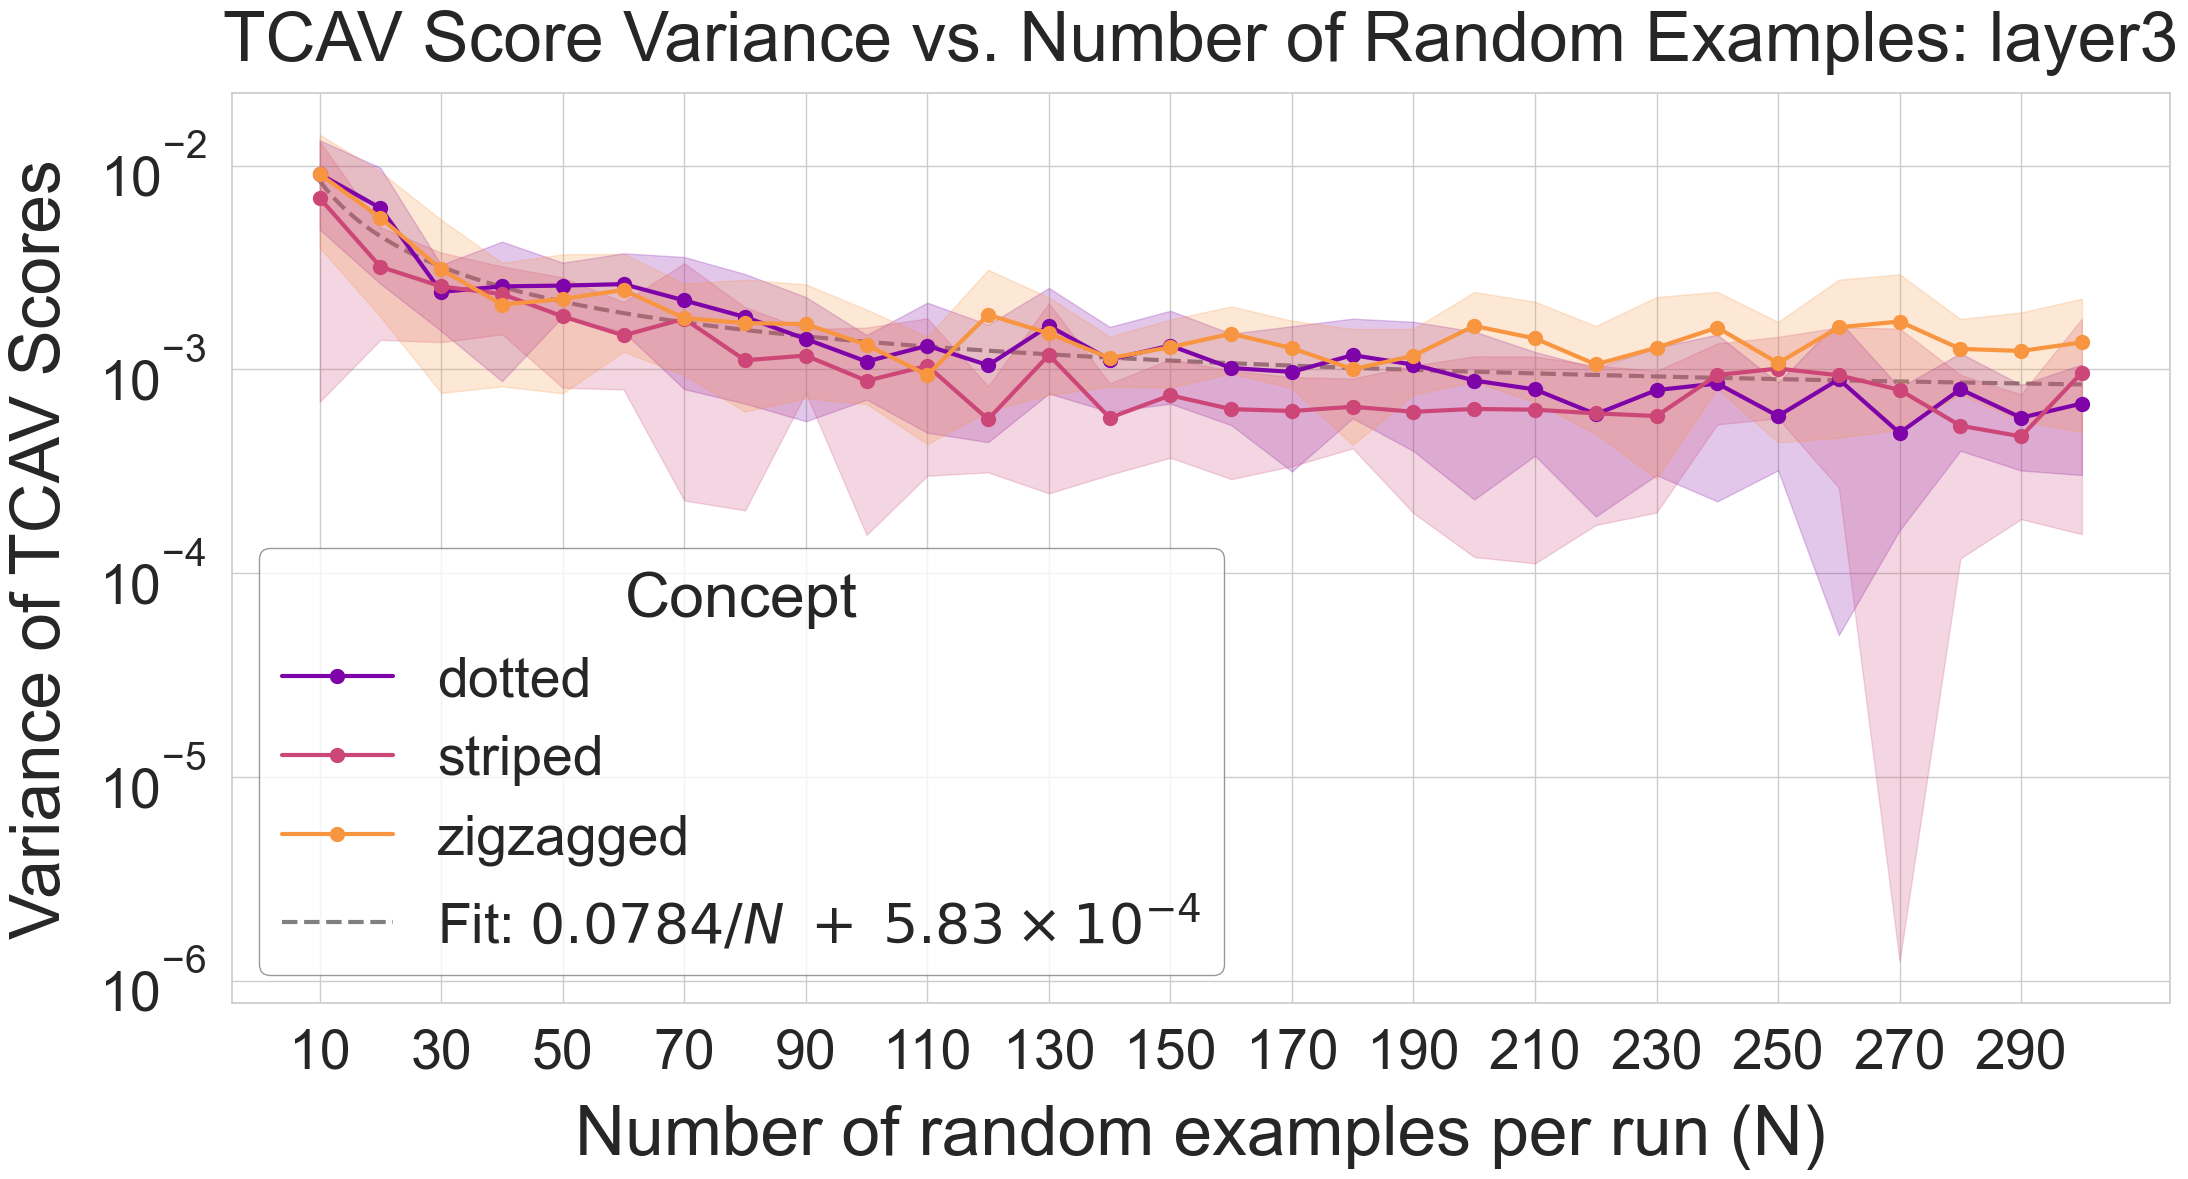

Plot saved to artifacts/images/resnet50/logistic/plots/tcav_score_variance_resnet50_layer4_logistic.pdf


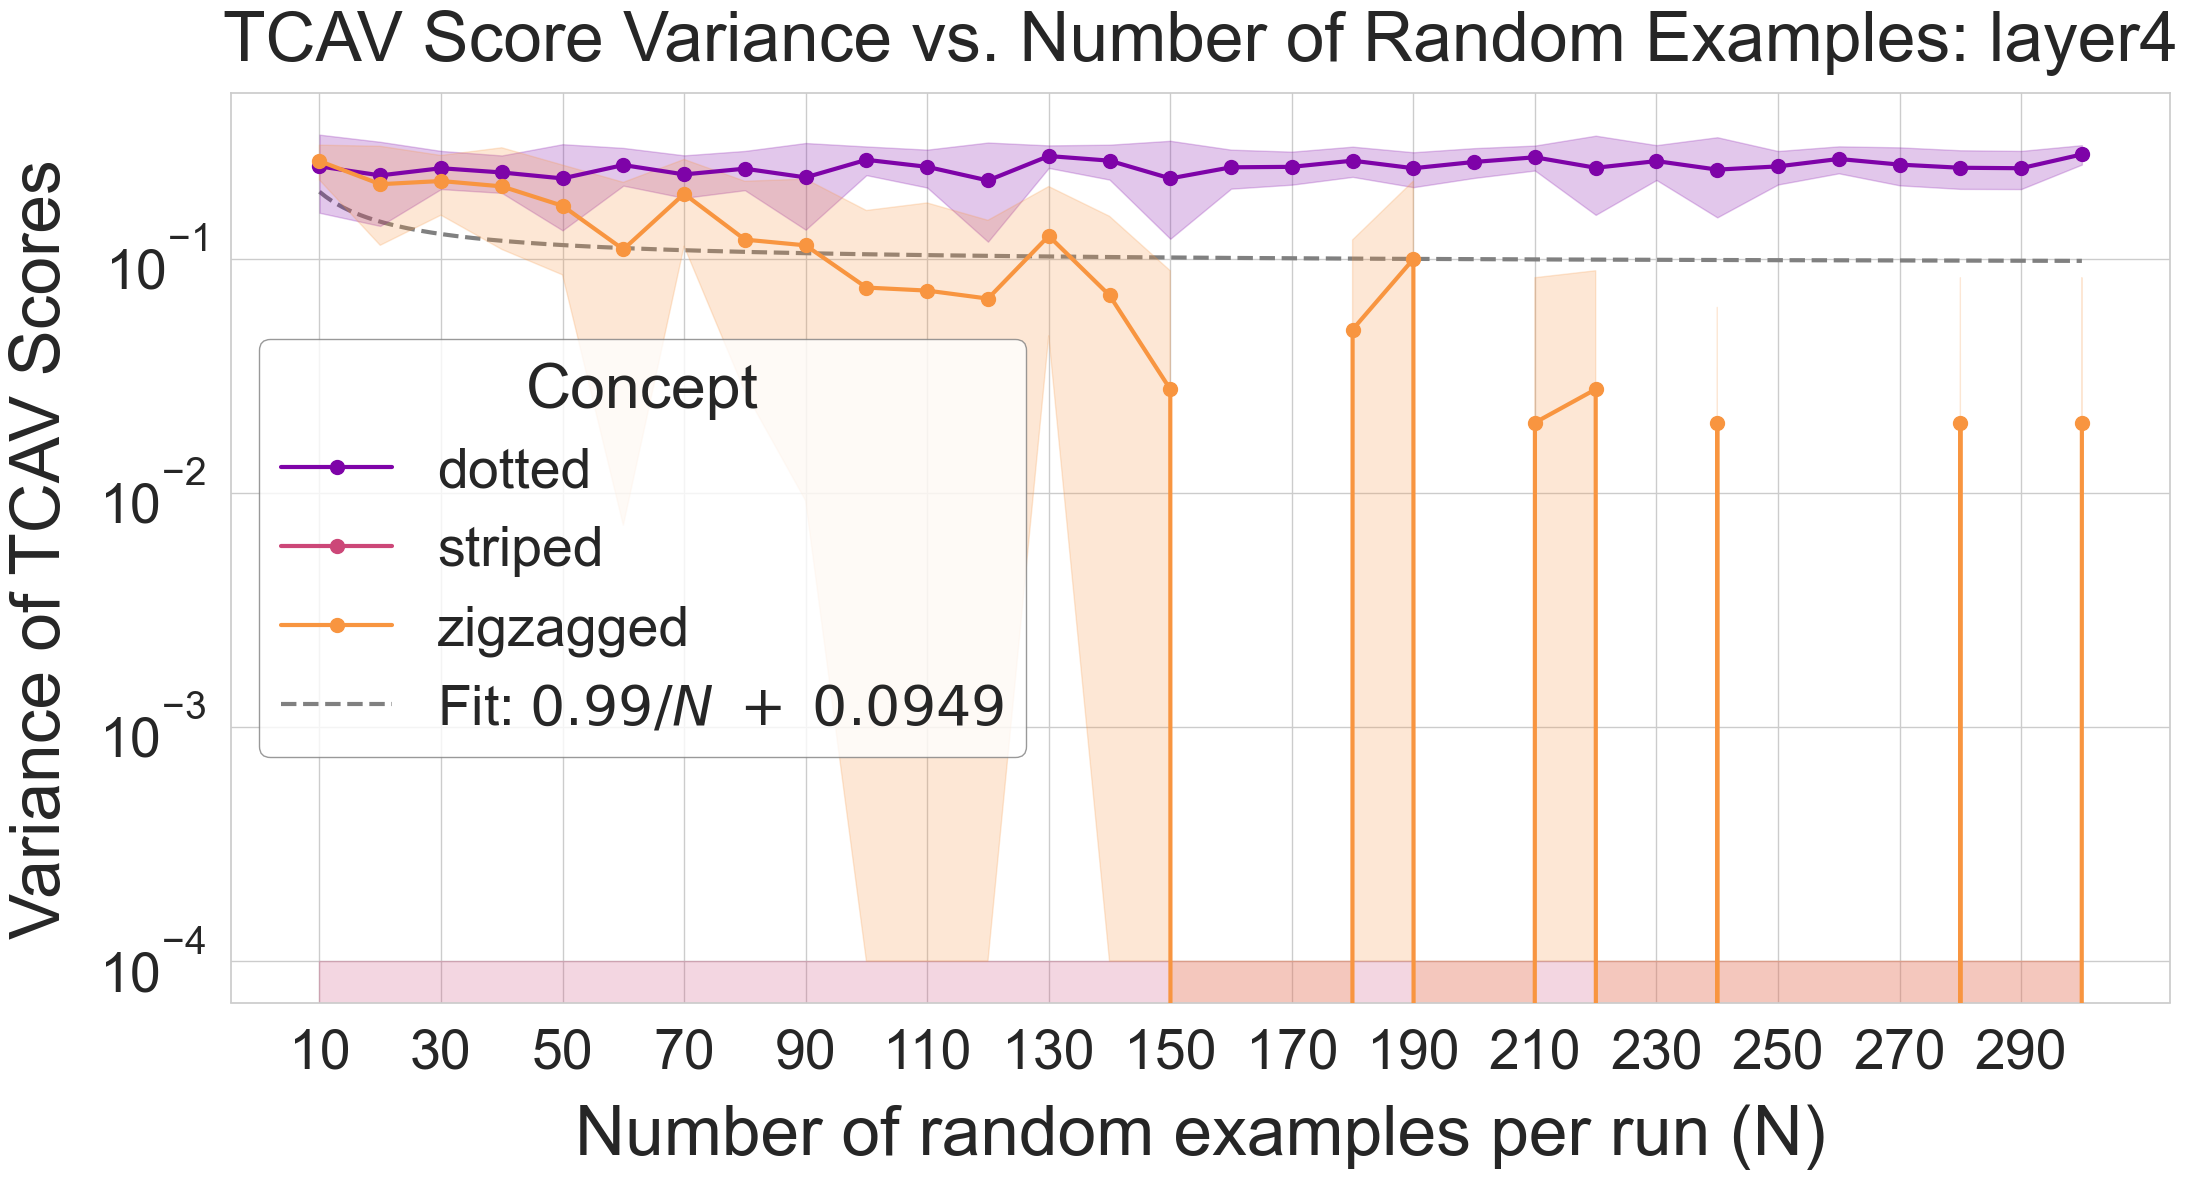

In [16]:
# (d) Plot TCAV score variance per layer (all concepts)
for layer in layers:
    if layer not in grads_by_layer:
        print("Skipping TCAV score plot for", layer, "(no gradients).")
        continue
    df_tcav = calculate_tcav_score_variance_cached(
        layers=[layer],
        concepts_to_load=cfg.dataset.concepts,
        n_values=list(cfg.n_values),
        runs=int(cfg.runs),
        gradients_per_layer=grads_by_layer,
        cav_output_dir=cfg.out_dir,
        cache_dir=CACHE_DIR,
        cache_key=f"tcav_score_var__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save=True,
    )
    # Filter to this layer in case multiple present
    df_layer = df_tcav[df_tcav["layer"] == layer].copy()
    plot_tcav_score_variance(
        df=df_layer,
        layer_name=layer,
        palette ="plasma",
        save_path=os.path.join(cfg.out_dir, "plots", f"tcav_score_variance_{MODEL}_{layer}_{METHOD}.pdf"),
        cache_dir=CACHE_DIR,
        cache_key=f"tcav_score_var_plot__{cfg.dataset.name}_{cfg.method}_{layer}",
        load_if_exists=LOAD_IF_EXISTS,
        save_bundle=True,
    )